# Random Forest Model

In [280]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [281]:
# Load the dataset
file_path = './Data/heart.csv'
df = pd.read_csv(file_path)

# Convert string data to appropriate type; object -> string
string_col = df.select_dtypes(include="object").columns
df[string_col] = df[string_col].astype("string")
print(df.dtypes) # check if converted properly

Age                        int64
Sex               string[python]
ChestPainType     string[python]
RestingBP                  int64
Cholesterol                int64
FastingBS                  int64
RestingECG        string[python]
MaxHR                      int64
ExerciseAngina    string[python]
Oldpeak                  float64
ST_Slope          string[python]
HeartDisease               int64
dtype: object


#### categorical features: Age, ChestPainType, RestingECG, ExcerciseAgina, ST_Slope

In [282]:
# Remove rows where RestingBP or Cholesterol columns have zero values
cleaned_df = df[(df['RestingBP'] != 0) & (df['Cholesterol'] != 0)]

# Save the cleaned dataset to a new CSV file
cleaned_file_path = 'cleaned_heart.csv'
cleaned_df.to_csv(cleaned_file_path, index=False)

# Display the first few rows of the cleaned dataframe
print(cleaned_df.head())

file_path = './Data/cleaned_heart.csv'
df = pd.read_csv(file_path)

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


### Handling Categorical Variables
For Tree based Machine Learning Algorithms the best way to go is with Label Encoding.

In [283]:
# distribution of categorical values:
df[string_col].head()
for col in string_col:
    print(f"The distribution of categorical valeus in the {col} is : ")
    print(df[col].value_counts())

The distribution of categorical valeus in the Sex is : 
Sex
1    564
0    182
Name: count, dtype: int64
The distribution of categorical valeus in the ChestPainType is : 
ChestPainType
0    370
2    169
1    166
3     41
Name: count, dtype: int64
The distribution of categorical valeus in the RestingECG is : 
RestingECG
1    445
0    176
2    125
Name: count, dtype: int64
The distribution of categorical valeus in the ExerciseAngina is : 
ExerciseAngina
0    459
1    287
Name: count, dtype: int64
The distribution of categorical valeus in the ST_Slope is : 
ST_Slope
1    354
2    349
0     43
Name: count, dtype: int64


In [284]:
# label encoding of categorical variables (this is fine for random forest)
# Initialize a dictionary to store label encoders
label_encoders = {}

# Label encoding of categorical variables
for col in string_col:
    le = LabelEncoder() # initialize label encoder
    df[col] = le.fit_transform(df[col])
    # fit: During the fitting process, LabelEncoder learns the unique classes present in the data and assigns each class a unique integer.
    # transform: After learning the classes, it then transforms the original categorical values into their corresponding integer codes.
    label_encoders[col] = le

In [285]:
# Print the label encoding mapping for each categorical feature
for col in string_col:
    le = label_encoders[col]
    print(f"Label encoding for {col}:")
    for class_, label in zip(le.classes_, le.transform(le.classes_)):
        print(f"{class_} -> {label}")
    print()

Label encoding for Sex:
0 -> 0
1 -> 1

Label encoding for ChestPainType:
0 -> 0
1 -> 1
2 -> 2
3 -> 3

Label encoding for RestingECG:
0 -> 0
1 -> 1
2 -> 2

Label encoding for ExerciseAngina:
0 -> 0
1 -> 1

Label encoding for ST_Slope:
0 -> 0
1 -> 1
2 -> 2



#### Scaling Numerical Features:
Why?
1. increased performance
2. model stability

Scaling is basically standardization...


In [286]:
# Split the data into features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Scale numerical features 
scaler = StandardScaler()
X = scaler.fit_transform(X)
# fit: compute mean and standard deviation for each feature from the training data
# transform: standardization (ensure each feature has mean: 0 and standard deviation: 1)

#### K-fold cross-validation procedure for estimating performance of model:

1. K-fold cross-validation :
As you can see, we divide the samples and the targets associated with them. We can divide the data into k different sets which are exclusive of each other. This is known as k-fold cross-validation, We can split any data into k-equal parts using KFold from scikit-learn. Each sample is assigned a value from 0 to k-1 when using k-fold cross validation.

2. Stratified k-fold cross-validation :
If you have a skewed dataset for binary classification with 90% positive samples and only 10% negative samples, you don't want to use random k-fold cross-validation. Using simple k-fold cross-validation for a dataset like this can result in folds with all negative samples. In these cases, we prefer using stratified k-fold cross-validation. Stratified k-fold cross-validation keeps the ratio of labels in each fold constant. So, in each fold, you will have the same 90% positive and 10% negative samples. Thus, whatever metric you choose to evaluate, it will give similar results across all folds.

In [287]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# model with randomized params 

In [288]:
# Define the stratified k-fold cross-validation procedure
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='roc_auc')
# Print cross-validation results
print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC-AUC Score: {cv_scores.mean()}")

Cross-Validation ROC-AUC Scores: [0.93936966 0.93418202 0.92759119 0.93625858 0.90790899]
Mean ROC-AUC Score: 0.929062086192368


#### Random Forest Model:
1. Build new data set from original data : randomly select the data while keeping the same number of rows with the original data set. (redundancy is allowed!) : Bootstrapping or Bagging
 
2.  While we don't use all the features for training the trees, we randomly select subset of features and use only them for training.

3. The prediction is done by passing in a new data for all the trees generated, and choose the majority voting.
![Screenshot 2024-07-03 at 3.09.44 AM.png](<attachment:Screenshot 2024-07-03 at 3.09.44 AM.png>)

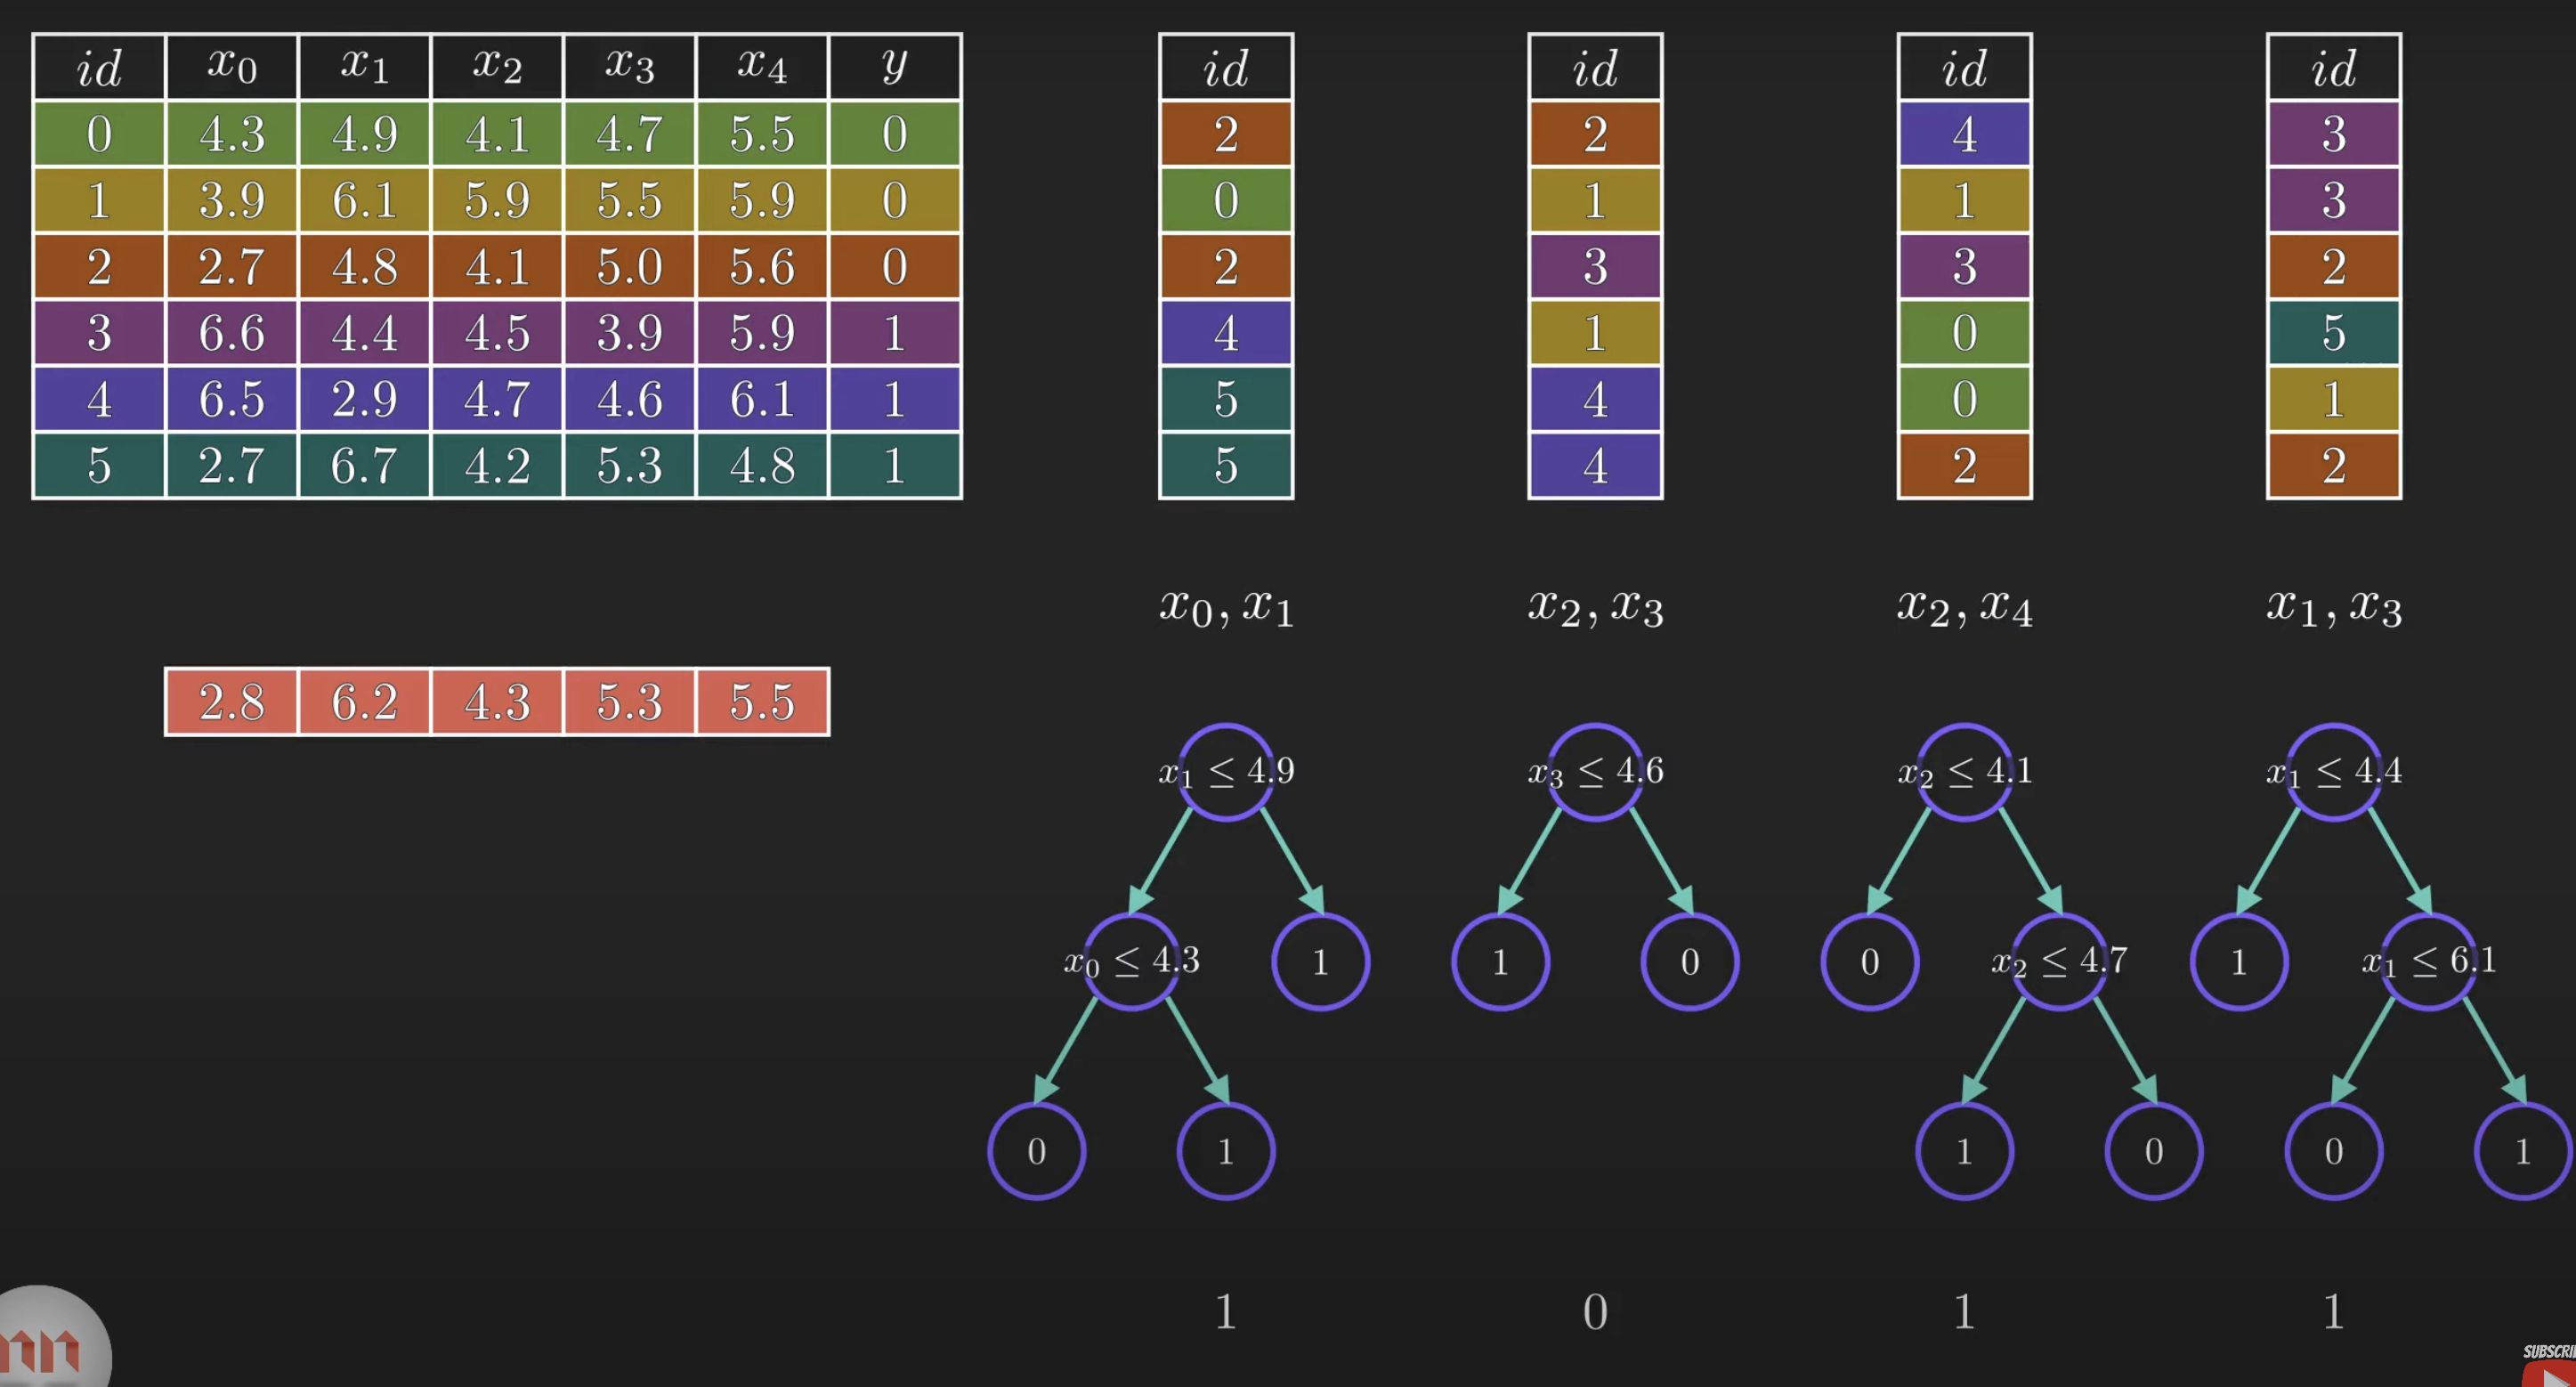

In [289]:
# # Convert X back to DataFrame to retain column names
# X = pd.DataFrame(X, columns=df.drop('HeartDisease', axis=1).columns)

In [290]:
n_estimators_range = range(1, 201, 10) # Define a range of n_estimators
# List to store accuracy for each value of n_estimators
accuracy_scores = []
# Loop over the n_estimators_range
for n in n_estimators_range:
    # Define the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n, random_state=90)
    
    # Perform cross-validation and calculate accuracy
    cv_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')
    
    # Append the mean accuracy to the list
    accuracy_scores.append(np.mean(cv_scores))

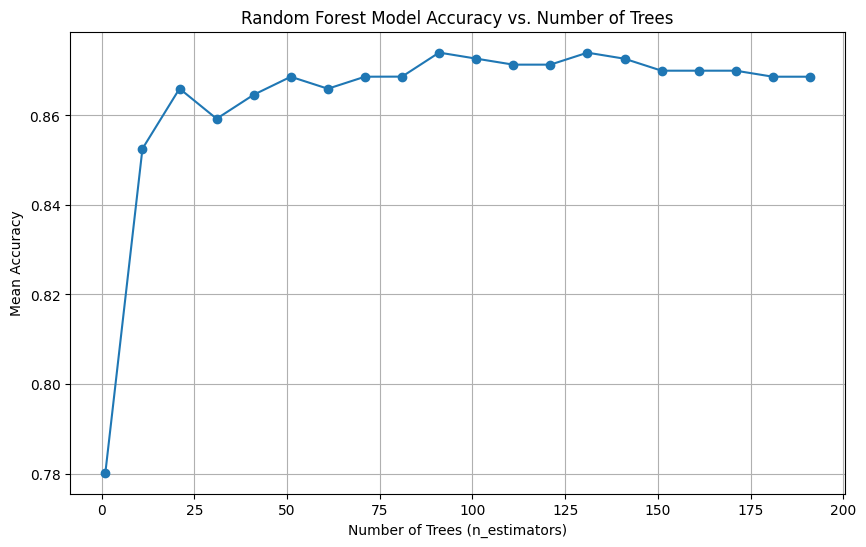

In [291]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Accuracy')
plt.title('Random Forest Model Accuracy vs. Number of Trees')
plt.grid(True)
plt.show()

Considering the plateu of the model accuracy around the number of trees between 140 - 160, we have chosen the hyper parameter value n_estimators as 152 for max accuracy.

In [292]:
# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=152, random_state=90) 
# n_estimators : number of decision trees generated
# random_state : random seed for reproducibility 


#### Testing and Training:

In [293]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
'''
Input:

X: The feature matrix (input)
y: The target vector (output)
test_size=0.2: Specifies that 20% of the data should be used for testing, and the remaining 80% for training.
random_state=42: Ensures reproducibility by setting a fixed seed
'''

'''
Output:

X_train: Training set features.
X_test: Testing set features.
y_train: Training set labels.
y_test: Testing set labels.
'''

'\nOutput:\n\nX_train: Training set features.\nX_test: Testing set features.\ny_train: Training set labels.\ny_test: Testing set labels.\n'

In [294]:
# Train the Random Forest model on the training set
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=152, random_state=90)

In [295]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test) # y_pred: Predicted class labels for the test set.
y_proba = rf_model.predict_proba(X_test)[:, 1]
'''
Function: predict_proba
The predict_proba method returns the class probabilities for the test set.

Output:
y_proba: Predicted probabilities of the positive class (heart disease) for the 
test set. The [:, 1] selects the probabilities of the positive class, 
assuming a binary classification problem where 0 is the negative class and 
1 is the positive class.
'''

'\nFunction: predict_proba\nThe predict_proba method returns the class probabilities for the test set.\n\nOutput:\ny_proba: Predicted probabilities of the positive class (heart disease) for the \ntest set. The [:, 1] selects the probabilities of the positive class, \nassuming a binary classification problem where 0 is the negative class and \n1 is the positive class.\n'

#### Evaluation:

In [296]:
# Evaluate the model
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

           0       0.84      0.96      0.89        71
           1       0.96      0.84      0.89        79

    accuracy                           0.89       150
   macro avg       0.90      0.90      0.89       150
weighted avg       0.90      0.89      0.89       150

ROC-AUC Score: 0.9568550543768942
Model Accuracy: 89.33%


#### Feature Importance:

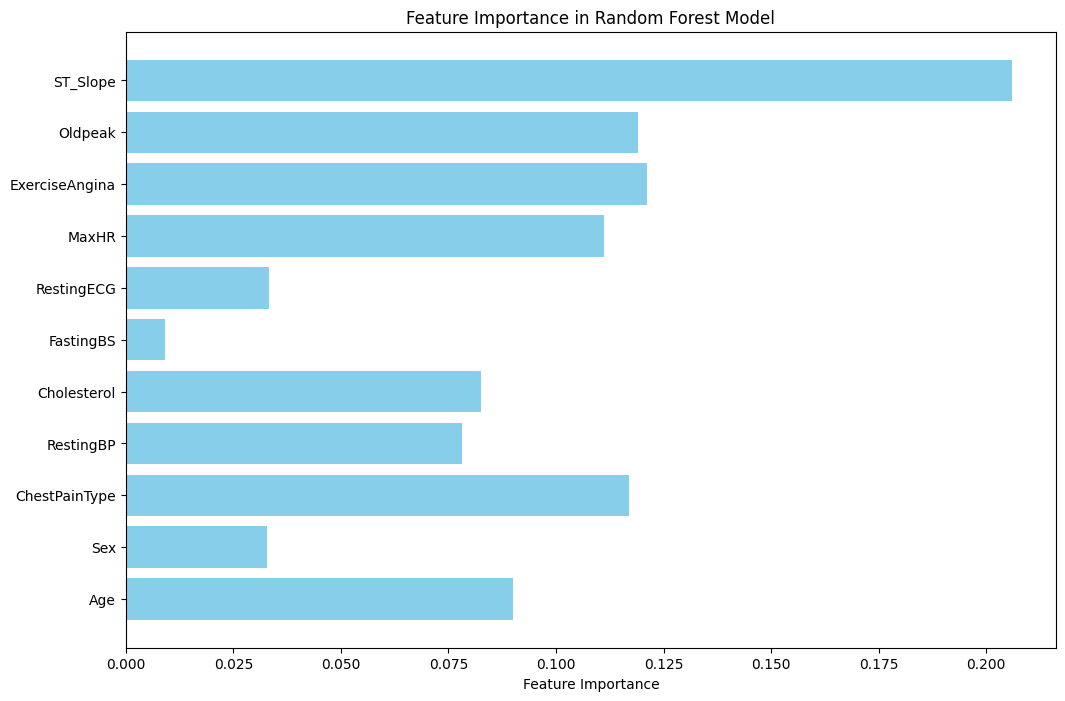

In [297]:
# Plot feature importance
feature_importances = rf_model.feature_importances_
features = df.drop('HeartDisease', axis=1).columns

plt.figure(figsize=(12, 8))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()

In [298]:
new_data = pd.DataFrame({
    'Age': [45],
    'Sex': ['Male'],
    'ChestPainType': ['ASY'],
    'RestingBP': [130],
    'Cholesterol': [233],
    'FastingBS': [1],
    'RestingECG': ['Normal'],
    'MaxHR': [150],
    'ExerciseAngina': ['N'],
    'Oldpeak': [0.2],
    'ST_Slope': ['Up']
})

# Encode new data using the same label encoders
for col in new_data.columns:
    if col in string_col:
        le = label_encoders[col]
        new_data[col] = new_data[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Scale new data
new_data_scaled = scaler.transform(new_data)

# Predict the risk
risk_percentage = rf_model.predict_proba(new_data_scaled)[:, 1] * 100
print("Predicted risk of heart failure: {:.2f}%".format(risk_percentage[0]))

Predicted risk of heart failure: 34.21%


### (Recursive) Feature Elimination:

In [299]:
from sklearn.feature_selection import RFE
# Perform RFE to select top features
n_features_to_select = 9  # Number of features you want to select
rfe = RFE(estimator=rf_model, n_features_to_select=n_features_to_select)
rfe.fit(X, y)

# Get the selected features
selected_features = rfe.support_
feature_names = df.drop('HeartDisease', axis=1).columns
selected_feature_names = feature_names[selected_features]
print("Selected Features:", selected_feature_names)

# Train a new model using only the selected features
X_selected = df[selected_feature_names]
X_selected = scaler.fit_transform(X_selected)

# Define the stratified k-fold cross-validation procedure
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_selected, y, cv=kf, scoring='roc_auc')
print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC-AUC Score: {cv_scores.mean()}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train the Random Forest model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Selected Features: Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')
Cross-Validation ROC-AUC Scores: [0.93785613 0.93761286 0.91856266 0.92822319 0.89689419]
Mean ROC-AUC Score: 0.9238298021748725
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        71
           1       0.93      0.82      0.87        79

    accuracy                           0.87       150
   macro avg       0.88      0.88      0.87       150
weighted avg       0.88      0.87      0.87       150

ROC-AUC Score: 0.9542699233374934
Model Accuracy: 87.33%


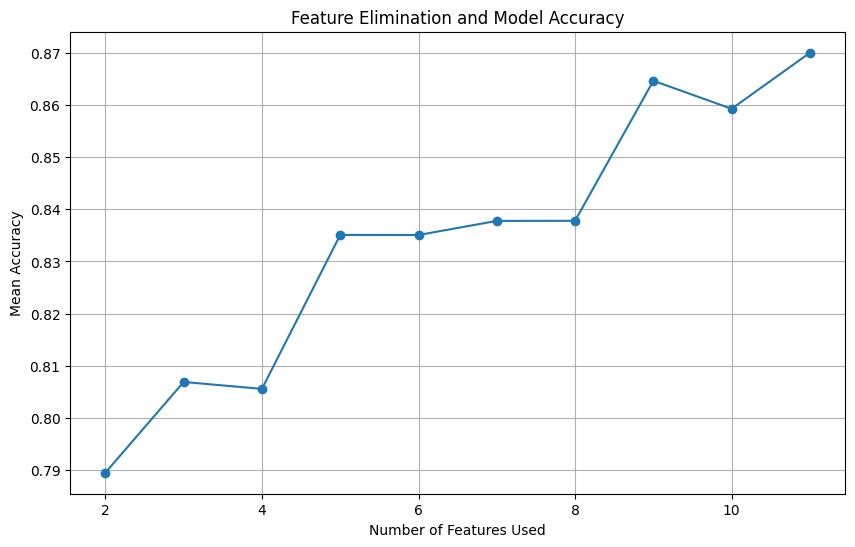

In [300]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the stratified k-fold cross-validation procedure
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize model and RFE
rf_model = RandomForestClassifier(n_estimators=152, random_state=90)
accuracies = []

# Iterate over the number of features to select
for n_features_to_select in range(2, X.shape[1] + 1):
    rfe = RFE(estimator=rf_model, n_features_to_select=n_features_to_select)
    rfe.fit(X_scaled, y)
    
    # Get the selected features
    selected_features = rfe.support_
    X_selected = X_scaled[:, selected_features]
    
    # Perform cross-validation and calculate mean accuracy
    cv_scores = cross_val_score(rf_model, X_selected, y, cv=kf, scoring='accuracy')
    mean_accuracy = np.mean(cv_scores)
    accuracies.append(mean_accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(2, X.shape[1] + 1), accuracies, marker='o')
plt.xlabel('Number of Features Used')
plt.ylabel('Mean Accuracy')
plt.title('Feature Elimination and Model Accuracy')
plt.grid(True)
plt.show()